In [12]:
import pandas as pd
from lightgbm import LGBMRegressor

## Model Training

In [13]:
df = pd.read_csv('./data/gemstone.csv')
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [14]:
#dropping id column as it is irrelevant to our analysis
df=df.drop(labels=['id'],axis=1)

In [15]:
## Seprating Independent and dependent features
X = df.drop(labels=['price'],axis=1)
Y = df[['price']]

In [16]:
#checking target variable
Y

,price
0,13619
1,13387
2,2772
3,666
4,14453
...,...
193568,1130
193569,2874
193570,3036
193571,681


In [17]:
# Defining which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

In [18]:
# Defining the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

In [19]:
# for handling Missing Values
from sklearn.impute import SimpleImputer 

# for Feature Scaling
from sklearn.preprocessing import StandardScaler 

# for Ordinal Encoding
from sklearn.preprocessing import OrdinalEncoder 

## for creating pipelines
from sklearn.pipeline import Pipeline

#for combining pipelines
from sklearn.compose import ColumnTransformer

In [20]:
# Numerical Pipeline
num_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())

    ]

)

# Categorigal Pipeline
cat_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
    ('scaler',StandardScaler())
    ]

)

preprocessor=ColumnTransformer([
('num_pipeline',num_pipeline,numerical_cols),
('cat_pipeline',cat_pipeline,categorical_cols)
])


In [21]:
## Train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=30)

In [22]:
#scaling dataset
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [23]:
#checking for scaling
X_train.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.975439,-0.849607,-0.121531,-1.042757,-1.080970,-1.123150,0.874076,1.528722,1.352731
1,0.235195,1.833637,-0.121531,0.318447,0.279859,0.485354,-2.144558,-0.935071,-0.646786
2,0.494617,0.815855,0.399800,0.570855,0.606458,0.673737,-0.132136,0.296826,0.686225
3,-1.018676,0.260701,0.921131,-1.214034,-1.244270,-1.195605,-0.132136,0.296826,0.019720
4,-0.953821,-0.664555,-0.642862,-1.069801,-1.044681,-1.094168,0.874076,2.144670,1.352731


In [24]:
## Model Training

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
import xgboost as xgb

#for metric evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [25]:
#function to evaluate model using mae,rmse and R2 score  
import numpy as np
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [26]:
## Training  multiple models

models={
    'LinearRegression':LinearRegression(),
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'Elasticnet':ElasticNet(),
    'Lightgbm':LGBMRegressor(),
    'XGboost':xgb.XGBRegressor()
}
trained_model_list=[]
model_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,y_train)

    #Make Predictions
    y_pred=model.predict(X_test)

    mae, rmse, r2_square=evaluate_model(y_test,y_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model Training Performance')
    print("RMSE:",rmse)
    print("MAE:",mae)
    print("R2 score",r2_square*100)

    r2_list.append(r2_square)
    
    print('='*35)
    print('\n')


LinearRegression
Model Training Performance
RMSE: 1013.9047094344003
MAE: 674.0255115796851
R2 score 93.68908248567512


Lasso
Model Training Performance
RMSE: 1013.8784226767013
MAE: 675.0716923362158
R2 score 93.68940971841704


Ridge
Model Training Performance
RMSE: 1013.9059272772381
MAE: 674.0555800810191
R2 score 93.68906732505846


Elasticnet
Model Training Performance
RMSE: 1533.4162456064046
MAE: 1060.7368759154729
R2 score 85.56494831165182


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1228
[LightGBM] [Info] Number of data points in the train set: 135501, number of used features: 9
[LightGBM] [Info] Start training from score 3970.766290
Lightgbm
Model Training Performance
RMSE: 578.6769211933583
MAE: 298.50019838441443
R2 score 97.94424882293809


XGboost
Model Trainin

In [27]:
#printing list of models used.
model_list

['LinearRegression', 'Lasso', 'Ridge', 'Elasticnet', 'Lightgbm', 'XGboost']

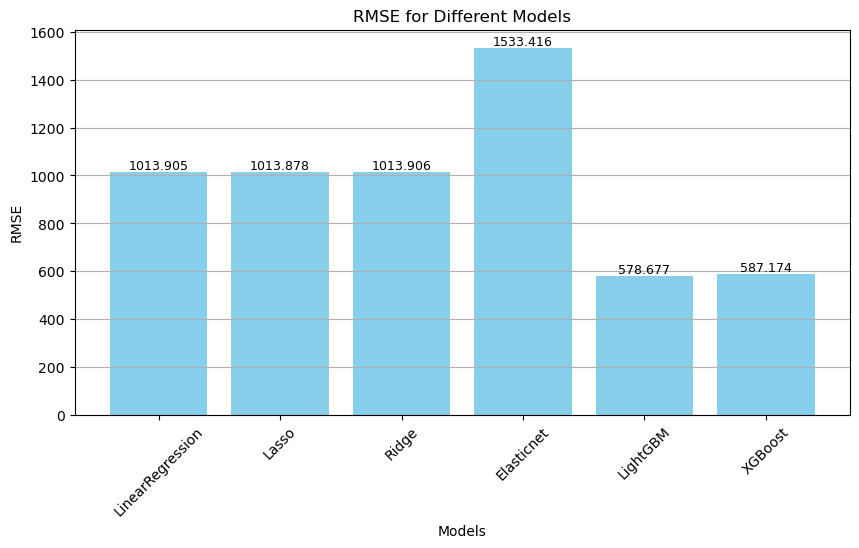

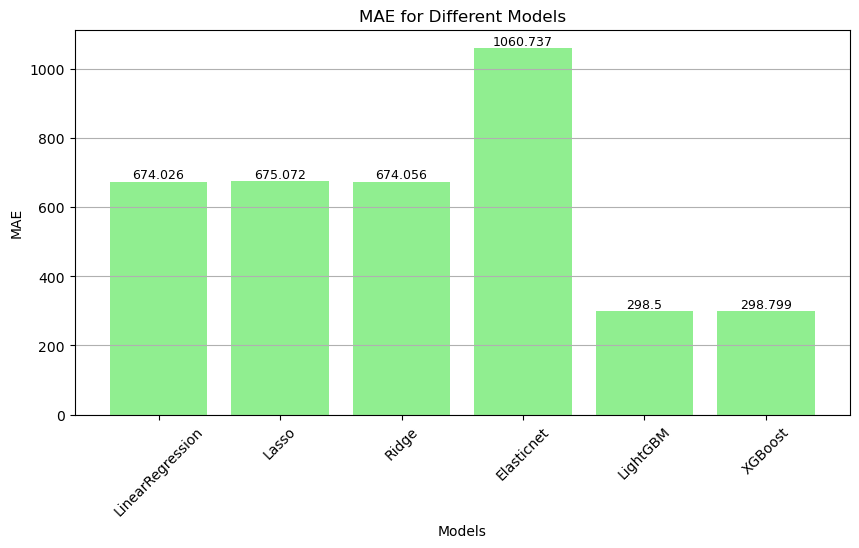

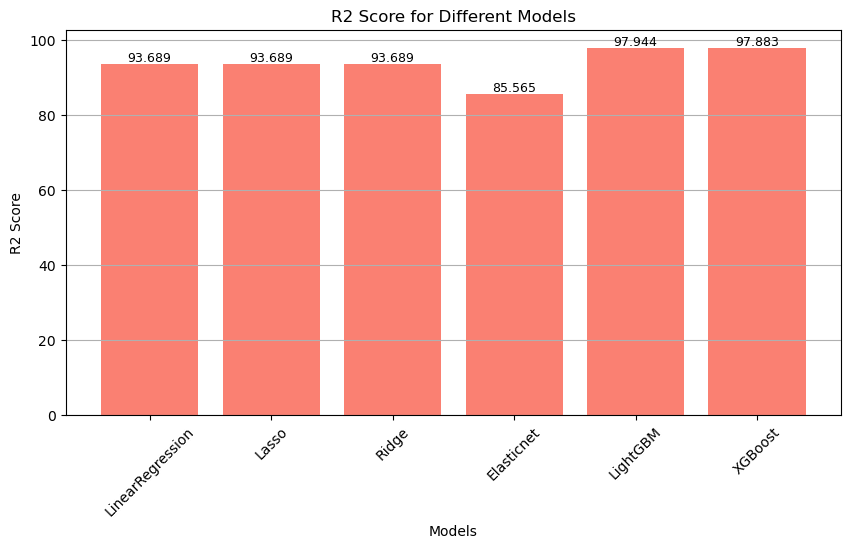

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LinearRegression', 'Lasso', 'Ridge', 'Elasticnet', 'LightGBM', 'XGBoost']

# Performance metrics (rounded to 3 decimal points)
rmse = [1013.905, 1013.878, 1013.906, 1533.416, 578.677, 587.174]
mae = [674.026, 675.072, 674.056, 1060.737, 298.500, 298.799]
r2_score = [93.689, 93.689, 93.689, 85.565, 97.944, 97.883]

# Plotting RMSE
plt.figure(figsize=(10, 5))
plt.bar(models, rmse, color='skyblue')
plt.title('RMSE for Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.gca().yaxis.grid(True)
for i, v in enumerate(rmse):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
plt.show()

# Plotting MAE
plt.figure(figsize=(10, 5))
plt.bar(models, mae, color='lightgreen')
plt.title('MAE for Different Models')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.gca().yaxis.grid(True)
for i, v in enumerate(mae):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
plt.show()

# Plotting R2 Score
plt.figure(figsize=(10, 5))
plt.bar(models, r2_score, color='salmon')
plt.title('R2 Score for Different Models')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.gca().yaxis.grid(True)
for i, v in enumerate(r2_score):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
plt.show()


In [ ]:

# 1. Linear Regression:
#    - Chosen as a baseline model due to its simplicity and interpretability. It provides a straightforward understanding of the relationship between the independent and dependent variables.

# 2. Lasso (L1 Regularized Linear Regression):
#    - Lasso is chosen for its ability to perform feature selection by shrinking some coefficients to zero. 
#      It helps in identifying the most relevant features in the dataset, especially when dealing with high-dimensional data.

# 3. Ridge (L2 Regularized Linear Regression):
#    - Ridge regression is chosen for its ability to handle multicollinearity in the dataset. 
#       It reduces the impact of correlated features and stabilizes the model by shrinking large coefficients.

# 4. Elastic Net:
#    - Elastic Net is chosen for its balanced approach between Lasso and Ridge regularization techniques. 
#      It provides a trade-off between feature selection and coefficient shrinkage, offering more flexibility and robustness in regularization.

# 5. LightGBM:
#    - LightGBM is chosen for its efficiency and scalability in handling large-scale datasets. 
#     It offers high accuracy and speed in training, making it suitable for real-world applications where computational resources are limited.

# 6. XGBoost (Extreme Gradient Boosting):
#    - XGBoost is chosen for its high performance and versatility in handling various types of data. 
#     It builds a series of decision trees sequentially to correct errors, leading to high predictive accuracy and robustness in different scenarios.

# # In summary, each model is chosen based on its specific characteristics and strengths. 
# Linear regression variants are chosen for their simplicity and interpretability, 
# while regularization techniques like Lasso and Ridge are chosen for their ability to handle feature selection and multicollinearity. 
# Gradient boosting models like LightGBM and XGBoost are chosen for their high accuracy and efficiency, especially for large-scale datasets. The choice of model depends on the specific characteristics of the dataset and the goals of the analysis.